# MRT data example

Here we fit a regression tree to the MRT data discussed in lectures.  We start by importing some libraries.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
import datetime
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree)

The first line reads in the MRT data to a pandas data frame with a single column.  The csv file has the column name 'x' in the first line, passing header=0 and giving the names argument explicitly overwrites the existing name to 'Ridership'.  Then create a date range to use as the index of the data frame and look at the first few lines.

In [19]:
MRT = pd.read_csv('MRT.csv',names=["Ridership"],header=0)
MRT_date=pd.date_range(start=datetime.datetime(2019,1,1),periods=48,freq="MS")
MRT.set_index(MRT_date,inplace=True)
MRT.head()

,Ridership
2019-01-01,3462
2019-02-01,3248
2019-03-01,3383
2019-04-01,3400
2019-05-01,3359


Create a new variable, months since January 2019

In [21]:
MRT.insert(0,"Months",np.arange(0,48))
MRT.head()

,Months,Ridership
2019-01-01,0,3462
2019-02-01,1,3248
2019-03-01,2,3383
2019-04-01,3,3400
2019-05-01,4,3359


Extract features and response (the second set of brackets in the index for X forces the column to be extracted 
as a data frame rather than a panda series).

In [23]:
X=MRT[['Months']]
feature_names=list(X)
y=MRT['Ridership']

Split into training and test data, using a 70%/30% training/test split.

In [24]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.3,
                                random_state=0)

Initialize a regression tree object, then grow the regression tree for the training data and plot.

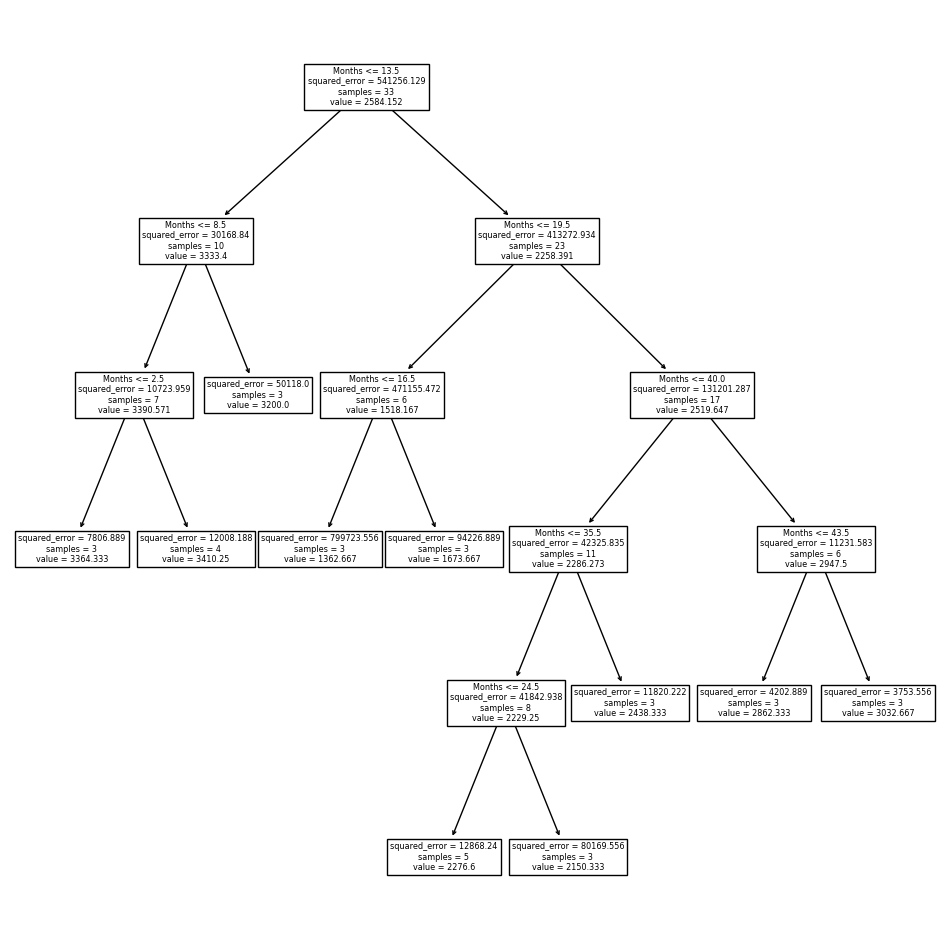

In [26]:
reg = DTR(min_samples_leaf=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);
#plt.savefig(fname="Lecture8-MRTFig1.pdf")

Next we select the best value of $\alpha$ for cost-complexity pruning based on 5-fold cross-validation with the training data.  We mentioned in class that the MRT data is a time series, but that we would treat it as a regression problem with independent responses and the time variable as a feature.  Cross-validation would normally be done differently for time series models, this will be ignored here. 

In [27]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

For the optimal choice of $\alpha$ and fitted tree to the training data, evaluate the performance on the test data.

In [28]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

87517.98285950419

Plot the pruned tree

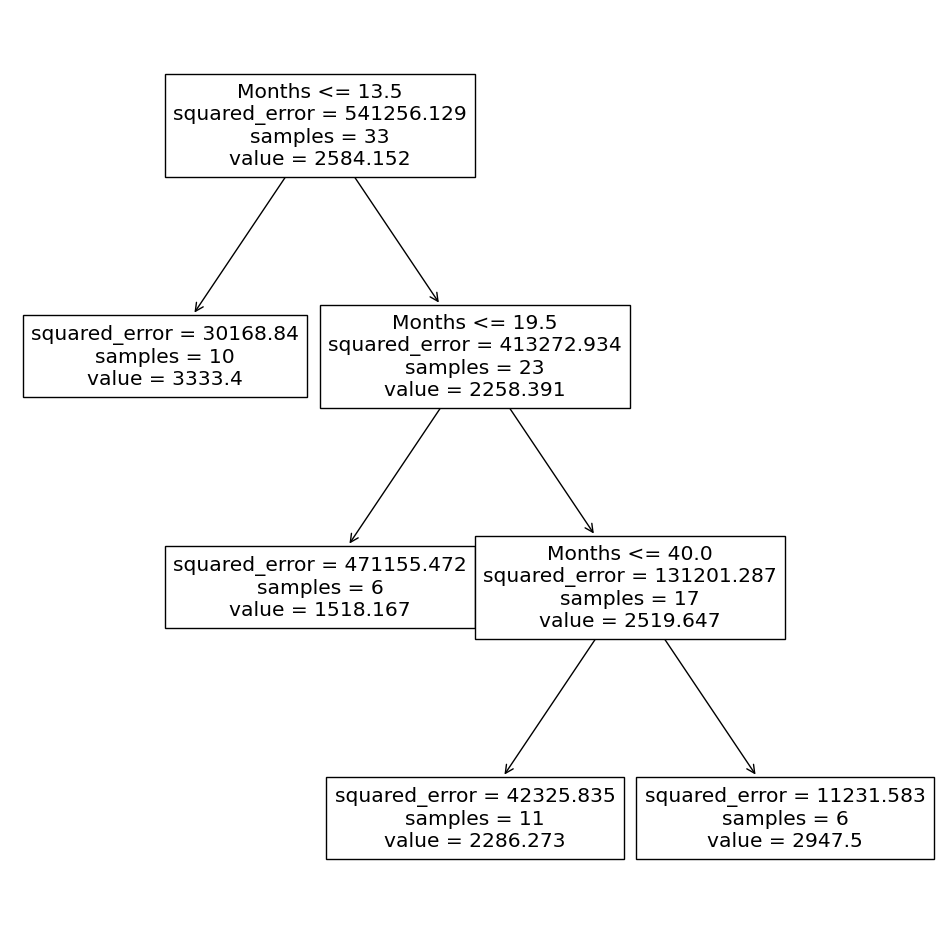

In [29]:
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
#plt.savefig(fname="Lecture8-MRTFig2.pdf")

Plot the trend over time for the fitted tree with the original data

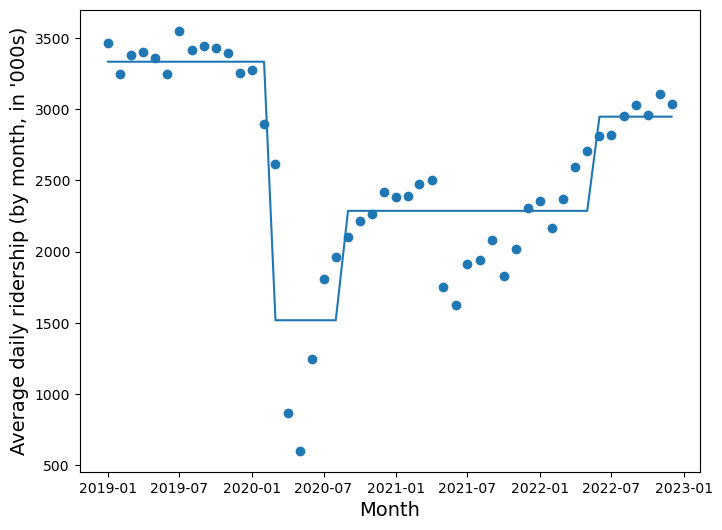

In [30]:
trend = best_.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(MRT.index,MRT.Ridership)
plt.xlabel("Month",size=14)
plt.ylabel("Average daily ridership (by month, in '000s)",size=14)
#plt.savefig(fname="Lecture8-MRTFig3.pdf")
ax.plot(MRT.index,trend)
#plt.savefig(fname="Lecture8-MRTFig4.pdf")
plt.show()